# Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pandas as pd

# Data Loading

In [26]:
#path to dataset
train_dir = '/content/drive/Shareddrives/COMP_647/Tumor_Dataset/Training'
test_dir = '/content/drive/Shareddrives/COMP_647/Tumor_Dataset/Testing'

# Data Preprocessing

In [34]:
#getting the list of all filenames and their respecteve classes
filenames = []
classes = []

for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    class_files = os.listdir(class_dir)
    filenames += [os.path.join(class_dir, f) for f in class_files]
    classes += [class_name for _ in class_files]

#splitting into training and validation sets
train_filenames, val_filenames, train_classes, val_classes = train_test_split(
    filenames, classes, test_size=0.2, random_state=42, stratify=classes)

#converting filenames and classes into a DataFrame for the training and validation set
train_df = pd.DataFrame({'filename': train_filenames, 'class': train_classes})
val_df = pd.DataFrame({'filename': val_filenames, 'class': val_classes})

#setting imag size and batch size, 224 is common size for CNNs like VGG, ResNet
img_height, img_width = 224, 224
batch_size = 32

##Notes for ImageDataGenerator

ImageDataGenerator is a tool tht can augment image data in real time while the model is training. Augmentation applies random transformations to the input images to increase the diversity of training set. Helps prevent overfitting and allows the model to generalize better to new data:

**rescale=1./255:** Normalization in that this scales each pixel value in the image from a range of 0-255 which is the normal range for image pixel values to a range of 0-1. Better performance for neural networks when normalize the input data.

**rotation_range=20:** This randomly rotates the image within a range of -20 to +20 degrees. helps the model handle cases where the tumor can be rotated in MRI scans.

**width_shift_range=0.2 and height_shift_range=0.2:** Randomly moves the image horizontally and vertically by a factor of the image's width and height .

**shear_range=0.2:** Shearing changes the shape of the object in a slanting manner; here, this gives a range between -20% to +20% from the vertical.

**zoom_range=0.2:** This randomly zooms the image in and out by up to 20%. (A zoom less than 1.0 magnifies the image, while a zoom greater than 1.0 shrinks the image)

**horizontal_flip=True:** This randomly flips the image horizontally from left to right. can be useful if the orientation of the tumor is not important

**fill_mode='nearest':** When using all these transformations, it may be possible that some pixels will need to be filled. This will fill in the missing pixels with the nearest pixel values.

In [35]:
#training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

initializing an ImageDataGenerator object for the test dataset. No augmentation needed becayse the test set evaluates the model's performance on data that hasn't been seen during training. So the test data should be processed the same as the training data minus the augmentation which allows for a fair comparison between the model's training performance and its expected performance on new data.

In [36]:
#test data generator with only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

This creates a train_generator, loads the images and applies the transformations:

Finds the images,
Resizes the images,
Processes per batch,
Prepares labels (one-hot encoding since we have multiclass classification for categorical variables),

When we train the model, this system will will give the model the info.

In [39]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2301 validated image filenames belonging to 4 classes.


Same process as above but now for val_generator

In [43]:
#the data is already augmented so no need for transformations, just rescale the pixel values for the validation generator
val_datagen = ImageDataGenerator(rescale=1./255)

#same process as for train and test generator, but now for validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 576 validated image filenames belonging to 4 classes.


Same process as above but now for test_generator

In [40]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 394 images belonging to 4 classes.


## Sample Image Visualizations Per Directory For Test Set

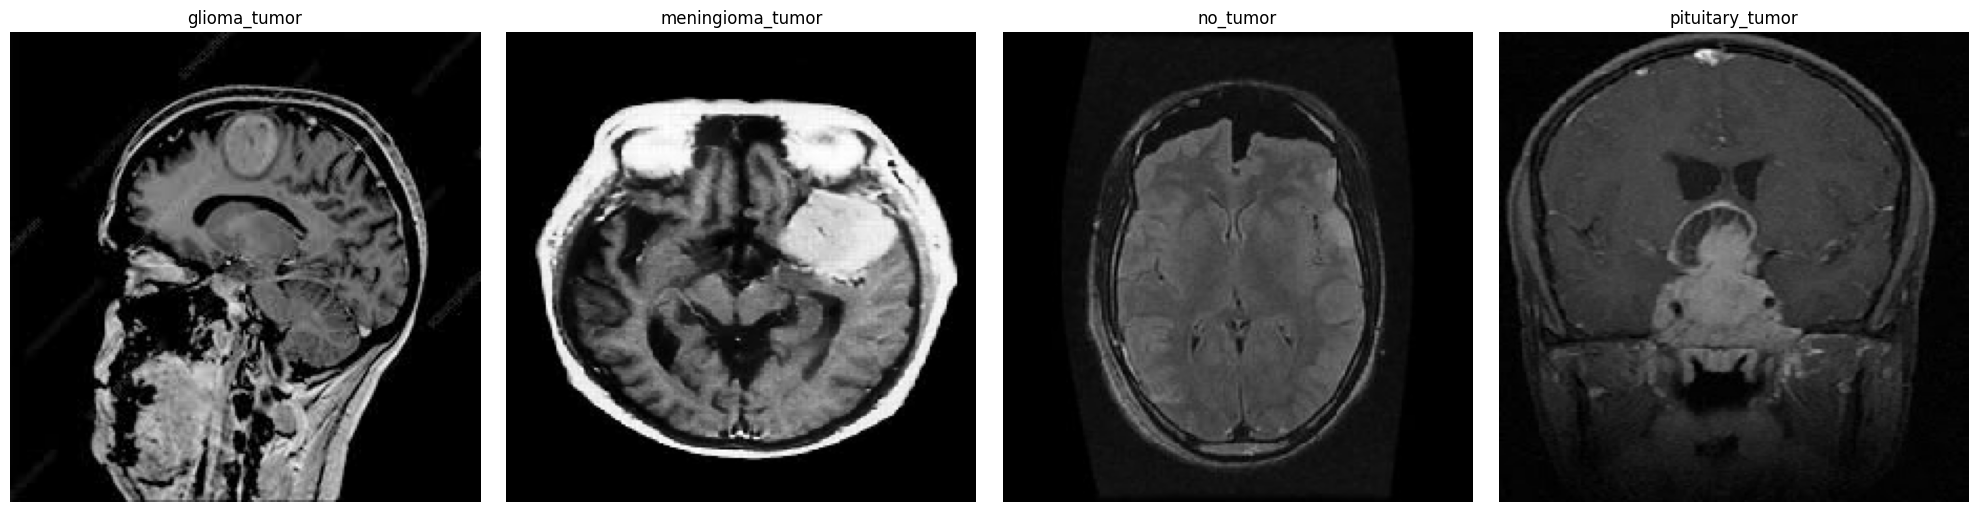

In [42]:
num_classes = 4
fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

for i, class_name in enumerate(sorted(os.listdir(test_dir))):
    class_dir = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

    img_path = os.path.join(class_dir, image_files[0])
    img = load_img(img_path, target_size=(224, 224))

    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()